# Modeling Demand for Cars with the IPDL model

In this notebook, we will explore the dataset used in
Goldberg & Verboven (2005). We will estimate the IPDL Model
model given the available data using the functions defined below.

Optimization terminated successfully.
         Current function value: 1.588275
         Iterations: 86
         Function evaluations: 1914
         Gradient evaluations: 87


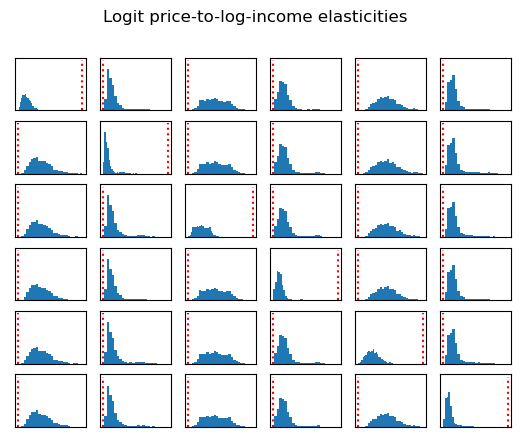

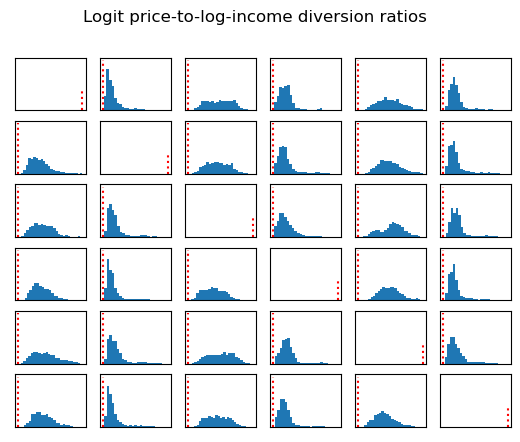

In [1]:
import numpy as np
import pandas as pd 
import os
from numpy import linalg as la
from scipy import optimize
from IPython import display
from matplotlib import pyplot as plt
import itertools as iter

# Files
import Logit_file as logit

Data
====

The dataset consists of approximately 110 vehicle makes per year in the period 1970-1999 in five european markets (Belgium, France, Germany, Italy, and the United Kingdom). Furthermore, the data contains information on various characteristics of the makes such as sales, prices, horse power, weight and other physical car characteristics. Also these characteristics may vary across markets. 

A observation in our analysis will be a market in a given year such that e.g. the French car market in 1995 counts as a single observation. If $Y = 30$ is the number of years, and $M = 5$ is the number of country-level markets, we thus have $T=Y\cdot M = 150$ markets and observations. In addition, since the available vehicle makes vary across time and place, let $\mathcal{J}_t$ denote the set of available makes in each market $t=1,\ldots,T$, and let $\mathcal{J} := \bigcup_{t=1}^T \mathcal{J}_t$ be the set of all makes which were available in some market. Then $J:=\#\mathcal{J}$ is the number of makes which were available at some point of time in the period in at least one country-level market. In our dataset there are $J = 356$ unique vehicle makes. Note also however that characteristics of vehicle makes vary across markets.

Our dataset includes 47 variables in total. The first three columns are market and product codes for the year, country, and make. Another variable is quantity sold (No. of new registrations) which will be used in computing observed market shares. The remaining 43 variables are potential explanatory variables. We will only consider the subset of these which describes car characteristics such as brand, after-tax price, horse power, etc. which adds up to $K=23$ characteristics. The remaining 20 variables are mainly macroeconomic variables such as e.g. GDP per capita which have been used to construct estimates of e.g. the average wage income and purchasing power. Since we are only interested in utility-shifting variables, we will not consider the latter columns. 

Reading in the dataset `eurocars.csv` we thus have a dataframe of $\sum_{t=1}^T \#\mathcal{J}_t = 11459$ rows and $47$ columns. The `ye` column runs through $y=70,\ldots,99$, the `ma` column runs through $m=1,\ldots,M$, and the ``co`` column takes values $j\in \mathcal{J}$. 

Because we consider a country-year pair as the level of observation, we construct a `market` column taking values $t=1,\ldots,T$. We also construct a `market_share` variable giving us the market share of any product $j$ in any market $t$; this will obviously take values in $[0,1]$. To deal with the fact that choice sets $\mathcal{J}_t$ vary across markets, we expand the dataframe so that every car $j\in \mathcal{J}$ which was observed in some market $t$ is in the choice set of all other markets as well, i.e. we impose $\mathcal{J}_t = \mathcal{J}$ for all markets $t$. We then impute a market share of $q_{jt}=0$ for any car $j$ which in reality was not available in market $t$. To this end we first construct an outside option $j=0$ in each market $t$  of not buying a car by letting the 'sales' of $j=0$ being determined as 

$$\mathrm{sales}_{0t} = \mathrm{pop}_t - \sum_{j=1}^J \mathrm{sales}_{jt}$$

where $\mathrm{pop}_t$ is the total population in market $t$.

We also read in the variable description of the dataset contained in `eurocars.dta`. We will use the list `x_vars` throughout to work with our explanatory variables.

Lastly, we access the underlying 3-dimensional numpy array of the explonatory variables `x` by sorting on `market` and then `co`, and subsequently resizing the explanatory variables as

> `x = dat[x_vars].values.resize((T,J,K))`

In [2]:
# Load dataset and variable names
os.chdir('../GREENCAR_notebooks/')
input_path = os.getcwd() # Assigns input path as current working directory (cwd)
descr = (pd.read_stata('eurocars.dta', iterator = True)).variable_labels()
dat = pd.read_csv(os.path.join(input_path, 'eurocars.csv'))

In [3]:
pd.DataFrame(descr, index=['description']).transpose().reset_index().rename(columns={'index' : 'variable names'})

,variable names,description
0,ye,year (=first dimension of panel)
1,ma,market (=second dimension of panel)
2,co,model code (=third dimension of panel)
3,zcode,alternative model code (predecessors and succe...
4,brd,brand code
5,type,name of brand and model
6,brand,name of brand
7,model,name of model
8,org,"origin code (demand side, country with which c..."
9,loc,"location code (production side, country where ..."


We now clean the data to fit our setup

In [4]:
### First we create the 'market' column 

dat = dat.sort_values(by = ['ye', 'ma'], ascending = True)
market_vals = [*iter.product(dat['ye'].unique(), dat['ma'].unique())]
market_vals = pd.DataFrame({'year' : [val[0] for val in market_vals], 'country' : [val[1] for val in market_vals]})
market_vals = market_vals.reset_index().rename(columns={'index' : 'market'})
dat = dat.merge(market_vals, left_on=['ye', 'ma'], right_on=['year', 'country'], how='left')

In [5]:
### Second we expand the dataset such that all cars are at least vacuously available in all markets

product_vals = [*iter.product(dat['market'].unique(), dat['co'].unique())]
product_vals = pd.DataFrame({'market' : [val[0] for val in product_vals], 'co' : [val[1] for val in product_vals]})
dat = product_vals.merge(dat, on=['market','co'], how='outer')
dat['qu'] = np.where(dat['qu'].isna(), 0, dat['qu'])

In [6]:
### Third we construct an outside option for each market t

outside_shares = dat.groupby('market', as_index=False)['qu'].sum()
outside_shares = outside_shares.merge(dat[['market', 'pop']], on = 'market', how='left').dropna().drop_duplicates(subset = 'market', keep = 'first')
outside_shares['qu'] = outside_shares['pop'] - outside_shares['qu']
outside_shares['co'] = 0
dat = pd.concat([dat, outside_shares])

# Potentially set characteristics equal to 0 for outside option. However consider different data types!

In [7]:
### Fourth we compute market shares for each product j in each market t 

dat['ms'] = dat.groupby('market')['qu'].transform(lambda x: x/x.sum())

In [8]:
# Determine explanatory variables and find variable description as 'x_lab'
x_vars =  [dat.keys()[k] for k in [*range(6,14), *range(15,30)]] 
x_lab = (pd.DataFrame(descr, index=['description'])[x_vars].transpose().reset_index().rename(columns={'index' : 'variable names'}))

In [9]:
x_lab

,variable names,description
0,type,name of brand and model
1,brand,name of brand
2,model,name of model
3,org,"origin code (demand side, country with which c..."
4,loc,"location code (production side, country where ..."
5,cla,class or segment code
6,home,domestic car dummy (appropriate interaction of...
7,frm,firm code
8,cy,cylinder volume or displacement (in cc)
9,hp,horsepower (in kW)


In [10]:
# Find the dimensions of Data
T = dat['market'].nunique()
J = dat['co'].nunique()
K = len(x_vars)

In [36]:
dat.keys()

Index(['market', 'co', 'ye', 'ma', 'zcode', 'brd', 'type', 'brand', 'model',
       'org', 'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do',
       'le', 'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'year', 'country', 'ms'],
      dtype='object')

Finally, we will primarily use numpy data types and numpy functions in this notebook. Hence we store our response variable 'y' and our explanatory variables 'x' as numpy arrays.

In [11]:
# Create numpy arrays of response and explanatory variables
dat = dat.sort_values(by = ['market', 'co']) # Sort data so that reshape is successfull
x = dat[x_vars].values.reshape((T,J,K))
y = dat['ms'].to_numpy()

#### Multinomial Logit - for comparison
Estimating a Logit model via maximum likelihood with an initial guess of parameters $\hat \beta^0 = 0$ yields estimated parameters $\hat \beta^{\text{logit}}$ given as...

In [12]:
beta_0 = np.zeros((K,))

# Estimate the model
res_logit = logit.estimate_logit(logit.q_logit, beta_0, a, x)

NameError: name 'a' is not defined

In [ ]:
logit_beta = res_logit['beta']
pd.DataFrame(logit_beta.reshape(1,len(logit_beta))) # Our estimates

We then compute the corresponding Logit choice probabilities

In [ ]:
logit_q = logit.logit_ccp(logit_beta, x)

We also find the elasticities and diversion ratios implied by the logit model as follows...

In [ ]:
epsilon_logit = logit.logit_elasticity(logit_q, logit_beta, 0) # Elasticities wrt. the price-to-log-income characteristic
DR_logit_hat = logit.logit_diversion_ratio(logit_q, logit_beta)

# The IPDL model - Nesting structure

The IPDL model is a generalization of the nested logit model where each alternative may belong to more than one nest. Before fully introducing the model, we construct the nesting structure.


## Constructing nests

Let $\Delta=\left\{q\in \mathbb{R}^J_+: \sum_{j=1}^J q_j=1\right\}$ denote the probability simplex. For each group of nests $g=1,\ldots, G$, nest membership is denoted by the matrix $\Psi^g\in \mathbb R^{C_g\times J}$: $\Psi^g_{cj}=1$ if product $j$ belongs to nest $c$ and zero otherwise, and each product can only belong to one nest within each group, meaning that $\sum_{c=1}^{C_g}\Psi^g_{cj}=1$ for all $j$ and all $g$. The matrix-vector product $\Psi^gq$ is then
$$
\Psi^g q=\sum_j \Psi^{g}_{cj}q_j=\left(\begin{array}{c}
\sum_{j:\Psi^g_{1j}=1} q_j \\
\vdots \\
\sum_{j: \Psi^g_{C_gj}=1}q_j
\end{array}\right),
$$
and the vector $\Psi^gq$ is a vector of nest-specific choice probabilities, i.e. the sum of the probabilities within each nest.

### The perturbation function $\Omega$

In the following, a vector $z\in \mathbb R^d$ is always a column vector. We now construct the IPDL perturbation function which has the form (where for a vector $z$, the logarithm is applied elementwise and $z'$ denote the transpose)
$$
\Omega(q|\lambda)= (1-\sum_{g=1}^G \lambda_g) q'\ln q +\sum_{g=1}^{G} \lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right).
$$
Note that since $\Psi^g q$ denotes a probability distribution over the nests, the term $(\Psi^gq)'\ln (\Psi^gq)$ is the (negative) entropy of the probability distribution $\Psi^g q$. Similarly, $q'\ln q$ is the negative entropy of q. Note also that as each nest has at least one member, and $q$ is strictly positive, $\Psi^gq$ is also strictly positive. When the parameters $\lambda_g$ satisfy $\lambda_g>0$ and
$$
\sum_g \lambda_g<1,
$$
the function $\Omega(\cdot|\lambda)$ is a strictly convex function of $q$, and the utility maximization problem has a unique interior (meaning strictly positive choice probabilities) solution. If $\lambda_g = 0$ for all groupings $g$, we immediately see that the  IPDL becomes the standard multinomial Logit model for the choice probabilities $q$. When there is only one group of nests, $G=1$, then $\Omega$ induces the nested logit choice probabilities (note though that the nested logit model is often parameterized in terms of the nesting parameter $\mu=1-\lambda$ instead!). 

It will be convenient to define a choice probability function for a given vector of payoffs $u$ as
$$
P(u|\lambda)=\arg \max_{q\in \Delta}\left\{q'u-\Omega(q|\lambda)\right\}
$$
Letting $\theta$ denote the full vector of parameters, $\theta=(\beta',\lambda')'$, the individual choice probabilities is a function of the matrix $\mathbf{X}_i$ and the parameters $\theta$, as
$$
p(\mathbf{X}_i,\theta)=\arg\max_{q\in \Delta}\left\{q'\mathbf{X}_i \beta-(1-\sum_{g=1}^G\lambda_g)q'\ln q-\sum_{g=1}^G\lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right)\right\}
$$

# Max-rescaling for numerical stability

Let $\alpha$ be a scalar, and let $\iota$ be the all-ones vector in $\mathbb R^J$. Note that $q'(u+\alpha\iota)=q'u+(q'\iota)\alpha=q'u+\alpha$, since $q$ sums to one. For this reason, $\alpha$ does not enter into the utility maximization when calculating $P(u+\alpha\iota|\lambda)$, and we have $P(u+\alpha\iota|\lambda)=P(u|\lambda)$.

This allows us to re-scale the utilities just as in the logit model, since $P(u-(\max_{j}u_j)\iota|\lambda)=P(u|\lambda)$. The numerical benefits of this approach carry over to the IPDL model.

## Gradient and Hessian

For purposes of computing the gradient and Hessian of $\Omega$, it is convenient to define
$$
\Gamma=\left(\begin{array}{c}
(1-\sum_g \lambda_g)I_J\\
\lambda_1 \Psi^1\\
\vdots\\
\lambda_G \Psi^G
\end{array}\right)
$$
where $I_J$ is the identity matrix in $\mathbb R^J$. The matrix $\Gamma$ is a block matrix with $J+\sum_g C_g$ rows and $J$ columns. Note that 

$$
\Gamma q=\left(\begin{array}{c}
(1-\sum_g\lambda_g)q \\
\lambda_1\Psi^g q\\
\vdots \\
\lambda_G \Psi^Gq
\end{array}\right)>0
$$
if $q>0$.

Using $\Gamma$, we can show that
$$
\Omega(q|\lambda)=(\Gamma q)'\ln (\Gamma q)+c\\
\nabla_q \Omega(q|\lambda)=\Gamma'\ln (\Gamma q)+\iota\\
\nabla^2_{qq}\Omega(q|\lambda)=\Gamma'\mathrm{diag}(\Gamma q)^{-1}\Gamma,
$$
where $c$ is a scalar that depends on $\lambda$ but not on $q$ and therefore does not affect the utility maximization problem, $\iota=(1,\ldots,1)'\in \mathbb R^J$ is the all-ones vector and $\mathrm{diag}(z)$ is a diagonal matrix with the elements of the vector $z$ on the diagonal.

In [101]:
def Create_nests(data, markets_id, products_id, columns):
    '''
    This function creates the nest matrices \Psi^g from any specified columns in data

    Args.
        data: a pandas DataFrame
        markets_id: a string denoting the column of 'data' containing an enumeration t=0,1,...,T-1 of markets
        products_id: a string denoting the column of 'data' containing product code which uniquely identifies products
        columns: a list containing the column names of columns in 'data' from which nest groupings g=0,1,...,G-1 for each market t are to be generated.

    Returns
        Psi_dict: a dictionary of dictionaries of the Psi_g matrices for each market t and each gropuing g
        nest_dict: a dictionary of dictionaries of pandas dataframes describing the structure of each nest for each market t and each grouping g 
    '''

    J = data[products_id].nunique()
    T = data[markets_id].nunique()
    G = len(columns)

    data = data.sort_values(by = [markets_id, products_id]) # This is good :)
    
    Psi_dict = {}
    nest_dict = {}

    for t in range(T):
        dat = data[data[markets_id] == t]
        Psi_t = {}
        nest_dict_t = {}

        for g in range(G):
            
            col = columns[g]
            vals = pd.DataFrame({'nests' : dat[col].sort_values().unique()}).reset_index().rename(columns={'index' :'nest_index'})
            descr = vals.rename_axis(col, axis='columns')
            nest_dict_t[g] = descr

            frame = dat[[products_id, col]].merge(vals, left_on = col, right_on = 'nests')
            allocation = frame[[products_id, 'nest_index']].reset_index().rename(columns={'index' : 'product_index'})
            C_g = dat[col].nunique()

            mat = np.zeros((int(C_g)+1, J))

            for c,j in zip(allocation['nest_index'], allocation['product_index']):
                mat[c, j] = 1

            Psi_t[g] = mat
        
        Psi_dict[t] = Psi_t
        nest_dict[t] = nest_dict_t

    return Psi_dict, nest_dict

In [102]:
Psi, Nest_descr = Create_nests(dat, 'market', 'co', x_vars)

In [111]:
len(Psi.keys())

150

In [142]:
def Create_Gamma(x, Lambda, Psi):
    '''
    This function 
    '''

    T,J,K = x.shape
    G = len(Lambda)

    lambda0 = 1 - sum(Lambda)
    Gamma =  [np.concatenate([lambda0*np.eye(J) if g==0 else Lambda[g-1]*Psi[t][g-1] for g in range(G+1)], axis=0) for t in range(T)]

    return Gamma

In [143]:
G = K
lambda0 = np.ones((G,))/(G+1)
Gamma0 = Create_Gamma(x, lambda0, Psi)

In [146]:
pd.DataFrame(Gamma0[2])

,0,1,2,3,4,5,6,7,8,9,...,347,348,349,350,351,352,353,354,355,356
0,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0


In [134]:
C0

[357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 357,
 66,
 55,
 57,
 58,
 41,
 74,
 58,
 66,
 61,
 55,
 77,
 69,
 70,
 69,
 61,
 72,
 62,
 68,
 60,
 65,
